In [3]:
#ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò
!conda list | grep xgboost
!conda list | grep lightgbm
!conda list | grep missingno
!pip list | grep scikit-learn

_py-xgboost-mutex         2.0                       cpu_0    conda-forge
libxgboost                1.3.3                h9c3ff4c_2    conda-forge
py-xgboost                1.3.3            py39hf3d152e_2    conda-forge
xgboost                   1.4.2                    pypi_0    pypi
lightgbm                  3.3.0                    pypi_0    pypi
missingno                 0.5.0                    pypi_0    pypi
scikit-learn                  1.0.2


In [20]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('Ïñçüí¢')

Ïñçüí¢


In [10]:
#Îç∞Ïù¥ÌÑ∞ ÏÇ¥Ìé¥Î≥¥Í∏∞

train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [11]:
#Îç∞Ïù¥ÌÑ∞ ÏπºÎüº Ï†ïÎ¶¨ÌïòÍ∏∞

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [12]:
#yÎ≥ÄÏàòÏóê price ÎÑ£Í∏∞, train ÏÇ≠Ï†ú

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [13]:
#id Ïª¨Îüº ÏÇ≠Ï†ú
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [14]:
#test Îç∞Ïù¥ÌÑ∞ Í∞ôÏùÄ ÏûëÏóÖ ÏßÑÌñâ
#priceÎäî ÏóÜÏúºÎãà priceÏóê ÎåÄÌïú Ï†ÑÏ≤òÎ¶¨ ÌïÑÏöîÏóÜÏùå
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
#ÌÉÄÍ≤ü Îç∞Ïù¥ÌÑ∞
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

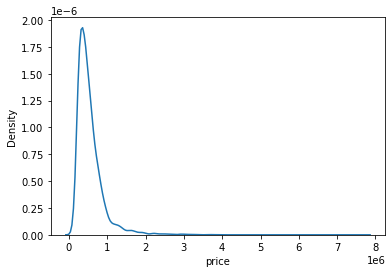

In [21]:
"""
seabornÏùò `kdeplot`ÏùÑ ÌôúÏö©Ìï¥ `y`Ïùò Î∂ÑÌè¨Î•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî!
"""

sns.kdeplot(y)
plt.show()

In [23]:
y = np.log1p(y) #log Î≥ÄÌôò
y

0        2.588515
1        2.572667
2        2.649161
3        2.599632
4        2.608893
           ...   
15030    2.661820
15031    2.696179
15032    2.624224
15033    2.631833
15034    2.616781
Name: price, Length: 15035, dtype: float64

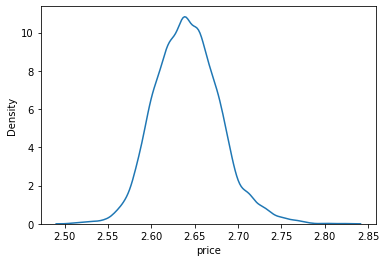

In [24]:
sns.kdeplot(y)
plt.show()

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [26]:
#RMSE Í≥ÑÏÇ∞
#Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖãÍ≥º Í≤ÄÏ¶ùÎç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÎÇòÎàÑÍ∏∞ ÏúÑÌï¥
#train_test_split Ìï®ÏàòÏôÄ, RMSE Ï†êÏàòÎ•º Í≥ÑÏÇ∞ÌïòÍ∏∞ ÏúÑÌïú mean_squareed_error Í∞ÄÏ†∏Ïò§Í∏∞

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('Ïñçüí¢')

Ïñçüí¢


In [27]:
#expm1 : Î∞òÎåÄÎ°ú Í∞Å ÏõêÏÜå xÎßàÎã§ exp(x)-1Ïùò Í∞íÏùÑ Î∞òÌôò
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('Ïñçüí¢')

Ïñçüí¢


In [28]:
#Î™®Îç∏ Í∞ÄÏ†∏Ïò§Í∏∞

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('Ïñçüí¢')

Ïñçüí¢


In [29]:
# random_stateÎäî Î™®Îç∏Ï¥àÍ∏∞ÌôîÎÇò Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ±Ïóê ÏÇ¨Ïö©ÎêòÎäî ÎûúÎç§ ÏãúÎìúÍ∞íÏûÖÎãàÎã§. 
#random_state=None    # Ïù¥Í≤å Ï¥àÍ∏∞Í∞íÏûÖÎãàÎã§. ÏïÑÎ¨¥Í≤ÉÎèÑ ÏßÄÏ†ïÌïòÏßÄ ÏïäÍ≥† NoneÏùÑ ÎÑòÍ≤®Ï£ºÎ©¥ Î™®Îç∏ ÎÇ¥Î∂ÄÏóêÏÑú ÏûÑÏùòÎ°ú ÏÑ†ÌÉùÌï©ÎãàÎã§.  
random_state=2020        # ÌïòÏßÄÎßå Ïö∞Î¶¨Îäî Ïù¥Î†áÍ≤å Í≥†Ï†ïÍ∞íÏùÑ ÏÑ∏ÌåÖÌï¥ ÎëêÍ≤†ÏäµÎãàÎã§. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('Ïñçüí¢')

Ïñçüí¢


In [31]:
df = {}

for model in models:
    # Î™®Îç∏ Ïù¥Î¶Ñ ÌöçÎìù
    model_name = model.__class__.__name__

    # train, test Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÎ¶¨ - Ïó¨Í∏∞ÏóêÎèÑ random_stateÎ•º Í≥†Ï†ïÌï©ÎãàÎã§. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # Î™®Îç∏ ÌïôÏäµ
    model.fit(X_train, y_train)
    
    # ÏòàÏ∏°
    y_pred = model.predict(X_test)

    # ÏòàÏ∏° Í≤∞Í≥ºÏùò rmseÍ∞í Ï†ÄÏû•
    df[model_name] = rmse(y_test, y_pred)
    
    # data frameÏóê Ï†ÄÏû•
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 0.1809232218184817,
 'XGBRegressor': 0.16679809240874063,
 'LGBMRegressor': 0.16314856105233844,
 'RandomForestRegressor': 0.1772598365624751}

In [33]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [34]:
from sklearn.model_selection import GridSearchCV

print('Ïñçüí¢')

Ïñçüí¢


In [35]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [36]:
model = LGBMRegressor(random_state=random_state)

print('Ïñçüí¢')

Ïñçüí¢


In [37]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [38]:
grid_model.cv_results_

{'mean_fit_time': array([0.16684623, 0.22060156, 0.4093009 , 0.5392127 ]),
 'std_fit_time': array([0.05571563, 0.06094008, 0.12460314, 0.0806094 ]),
 'mean_score_time': array([0.01364675, 0.01831546, 0.03121104, 0.0326251 ]),
 'std_score_time': array([0.00984972, 0.01445962, 0.01786465, 0.01057475]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.00037839, -0.00027917, -0.00014791, -0.00013679]),
 'split1_test_score': array([-0.00038423, -0.00029197, -0.00015652, -0.00014476]),
 'split2_test_score': array([-0.00037037

In [39]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [40]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.00036765, -0.00027737, -0.00015077, -0.00014011])

In [41]:
results = pd.DataFrame(params)
results['score'] = score

results

max_depth  n_estimators     score
0          1            50 -0.000368
1          1           100 -0.000277
2         10            50 -0.000151
3         10           100 -0.000140

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [42]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

max_depth  n_estimators     score      RMSE
0          1            50 -0.000368  0.019174
1          1           100 -0.000277  0.016655
2         10            50 -0.000151  0.012279
3         10           100 -0.000140  0.011837

In [43]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.000368  0.019174
1          1           100 -0.000277  0.016655
2         10            50 -0.000151  0.012279
3         10           100 -0.000140  0.011837

In [44]:
results = results.sort_values('RMSLE')
results

max_depth  n_estimators     score     RMSLE
3         10           100 -0.000140  0.011837
2         10            50 -0.000151  0.012279
1          1           100 -0.000277  0.016655
0          1            50 -0.000368  0.019174

In [45]:
"""
Îã§ÏùåÍ≥º Í∞ôÏùÄ Í≥ºÏ†ïÏùÑ ÏßÑÌñâÌï† Ïàò ÏûàÎäî `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` Ìï®ÏàòÎ•º Íµ¨ÌòÑÌï¥ Î≥¥ÏÑ∏Ïöî.

1. GridSearchCV Î™®Îç∏Î°ú `model`ÏùÑ Ï¥àÍ∏∞ÌôîÌï©ÎãàÎã§.
2. Î™®Îç∏ÏùÑ fitting Ìï©ÎãàÎã§.
3. params, scoreÏóê Í∞Å Ï°∞Ìï©Ïóê ÎåÄÌïú Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï©ÎãàÎã§. 
4. Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±ÌïòÍ≥†, RMSLE Í∞íÏùÑ Ï∂îÍ∞ÄÌïú ÌõÑ Ï†êÏàòÍ∞Ä ÎÜíÏùÄ ÏàúÏÑúÎ°ú Ï†ïÎ†¨Ìïú `results`Î•º Î∞òÌôòÌï©ÎãàÎã§.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV Î™®Îç∏Î°ú Ï¥àÍ∏∞Ìôî
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # Î™®Îç∏ fitting
    grid_model.fit(train, y)

    # Í≤∞Í≥ºÍ∞í Ï†ÄÏû•
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE Í∞í Í≥ÑÏÇ∞ ÌõÑ Ï†ïÎ†¨
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [47]:
#Í∑∏Î¶¨Îìú ÌÉêÏÉâ

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


max_depth  n_estimators     score     RMSLE
3         10           100 -0.000140  0.011837
2         10            50 -0.000151  0.012279
1          1           100 -0.000277  0.016655
0          1            50 -0.000368  0.019174

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.4s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.5s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.7s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[LightGBM] [Warning] Accuracy may be bad si

In [48]:
#Ìï¥Îãπ ÌååÎùºÎØ∏ÌÑ∞Î°ú Íµ¨ÏÑ±Îêú Î™®Îç∏ÏùÑ Ï§ÄÎπÑÌïòÍ≥†, ÌïôÏäµ ÌõÑ ÏòàÏ∏°Í≤∞Í≥º ÏÉùÏÑ±

model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([2.64364262, 2.64014739, 2.71797999, ..., 2.6413381 , 2.61577285,
       2.63572556])

In [49]:
#Ïä§ÏºÄÏùº ÎêòÎèåÎ¶¨Í∏∞

rediction = np.expm1(prediction)
prediction

array([13.06434146, 13.01526921, 14.14968879, ..., 13.03196719,
       12.67778315, 12.95343288])

In [50]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [51]:
submission['price'] = prediction
submission.head()

id      price
0  15035  13.064341
1  15036  13.015269
2  15037  14.149689
3  15038  12.673338
4  15039  12.704526

In [52]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [53]:
"""
ÏïÑÎûòÏùò Í≥ºÏ†ïÏùÑ ÏàòÌñâÌïòÎäî `save_submission(model, train, y, test, model_name, rmsle)` Ìï®ÏàòÎ•º Íµ¨ÌòÑÌï¥ Ï£ºÏÑ∏Ïöî.
1. Î™®Îç∏ÏùÑ `train`, `y`Î°ú ÌïôÏäµÏãúÌÇµÎãàÎã§.
2. `test`Ïóê ÎåÄÌï¥ ÏòàÏ∏°Ìï©ÎãàÎã§.
3. ÏòàÏ∏°Í∞íÏùÑ `np.expm1`ÏúºÎ°ú Î≥ÄÌôòÌïòÍ≥†, `submission_model_name_RMSLE_100000.csv` ÌòïÌÉúÏùò `csv` ÌååÏùºÏùÑ Ï†ÄÏû•Ìï©ÎãàÎã§.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [56]:
#Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ® ÌõÑ ÏòàÏ∏° Í≤∞Í≥ºÎ•º Ï†ÄÏû•

save_submission(model, train, y, test, 'lgbm', rmsle='0.02')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.02.csv saved!
